In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import pickle
import warnings

In [2]:
import tskit

In [3]:
def wf1(N, ngens):
    
    tables = tskit.TableCollection(1)
    nodes, edges = tables.nodes, tables.edges
    for i in range(2*N):
        nodes.add_row(time=0, flags=tskit.NODE_IS_SAMPLE)
        
    next_offspring_index = len(nodes)
    first_parental_index = 0
    for gen in range(1, ngens+1):
        assert(next_offspring_index == len(nodes))
        assert(first_parental_index == len(nodes)-2*N)
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1]< 0.5)
            
            nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
            nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
            
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index+1)
            
            next_offspring_index += 2
        first_parental_index += 2*N
        print(first_parental_index, next_offspring_index)
        
    return tables

In [4]:
np.random.seed(42)
tables = wf1(3,4)

6 12
12 18
18 24
24 30


In [9]:
tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,-1,4.00000000,b''
1,1,-1,-1,4.00000000,b''
2,1,-1,-1,4.00000000,b''
3,1,-1,-1,4.00000000,b''
4,1,-1,-1,4.00000000,b''
5,1,-1,-1,4.00000000,b''
6,1,-1,-1,3.00000000,b''
7,1,-1,-1,3.00000000,b''
8,1,-1,-1,3.00000000,b''
9,1,-1,-1,3.00000000,b''


In [6]:
tables.nodes.set_columns(time=-1.0*(tables.nodes.time - tables.nodes.time.max()),flags=tables.nodes.flags)

In [8]:
tables.sort()

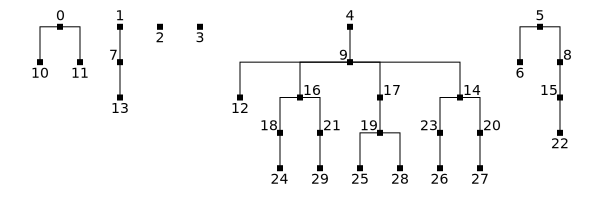

In [10]:


ts = tables.tree_sequence()
SVG(ts.first().draw(width=600))

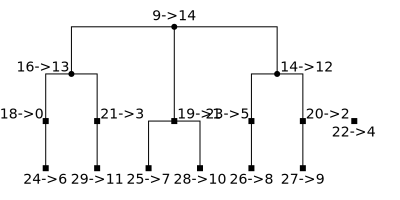

In [12]:
m=2

mask = [True if i in range(0,m) else False for i in tables.nodes.time]

samples=np.where(mask)[0]
samples

node_map = tables.simplify(samples=samples.tolist())

inverse_map = {node_map[node]: node for node in range(len(node_map))}

ts = tables.tree_sequence()
tree = ts.first()
inverse_map = {node_map[node]: node for node in range(len(node_map))}
labels = {u: "{}->{}".format(inverse_map[u], u) for u in tree.nodes()}
SVG(tree.draw(height=200, width=400, node_labels=labels))

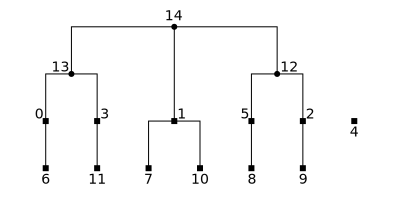

In [13]:
SVG(tree.draw(height=200, width=400))

In [15]:
tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,-1,1.00000000,b''
1,1,-1,-1,1.00000000,b''
2,1,-1,-1,1.00000000,b''
3,1,-1,-1,1.00000000,b''
4,1,-1,-1,1.00000000,b''
5,1,-1,-1,1.00000000,b''
6,1,-1,-1,-0.00000000,b''
7,1,-1,-1,-0.00000000,b''
8,1,-1,-1,-0.00000000,b''
9,1,-1,-1,-0.00000000,b''


In [14]:
tables.nodes.add_row(time=0, flags=tskit.NODE_IS_SAMPLE)

15

In [16]:
tables.edges.add_row(left=0, right=1, parent=13, child=15)

13

In [17]:
tables.sort()

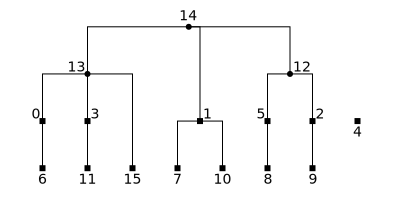

In [18]:
ts = tables.tree_sequence()
tree = ts.first()

SVG(tree.draw(height=200, width=400))

In [163]:
nodes, edges = tables.nodes, tables.edges

In [165]:
len(nodes), len(edges)

(15, 13)

In [170]:
next_offspring_index = len(nodes)
first_parental_index = 0 + 2*N*(m-1)

In [172]:
next_offspring_index, first_parental_index

(15, 6)

In [173]:
gen = 4

parents = np.random.randint(0, N, 2*N)
for parent1, parent2 in zip(parents[::2], parents[1::2]):
    mendel = np.random.random_sample(2)
    g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
    g2 = first_parental_index + 2*parent2 + (mendel[1]< 0.5)

    nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
    nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)

    edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
    edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index+1)

    next_offspring_index += 2
first_parental_index += 2*N

In [174]:
tables.nodes.set_columns(time=-1.0*(tables.nodes.time - tables.nodes.time.max()),
                  flags=tables.nodes.flags)
tables.sort()

ts = tables.tree_sequence()
SVG(ts.first().draw(width=600))

LibraryError: time[parent] must be greater than time[child]

In [101]:
def simplify_nodes_edges(tables, temp_nodes, dt):
    nodes, edges = tables.nodes, tables.edges
    if(len(edges) == 0):
        return tables
    nodes.set_columns(time=nodes.time+dt, flags=nodes.flags)
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
    gap = nodes.time.min()-t.max()
    assert(gap==1)
    nodes.append_columns(time=t,flags=temp_nodes.flags)
    tables.sort()
    samples = np.where(nodes.time == 0.0)[0]
    node_map = tables.simplify(samples=samples.tolist())
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))

In [105]:
def wf2(N, ngens, gc):
    if gc < 1:
        raise ValueError("gc must be a non-negative int")
        
    tables = tskit.TableCollection(1)
    nodes, edges = tables.nodes, tables.edges
    temp_nodes = tskit.NodeTable()
    for i in range(2*N):
        nodes.add_row(time=0, flags=tskit.NODE_IS_SAMPLE)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    last_gc_time = 0

    for gen in range(0,ngens):
        if gen % gc == 0.0:
            # Simplify the data
            simplify_nodes_edges(tables,temp_nodes,gen-last_gc_time)
            last_gc_time=gen
            temp_nodes.clear()
            next_offspring_index = len(nodes)
            first_parental_index = 0
            print(nodes)
            assert(all(nodes.time[:2*N] == 0.0))
        else:
            first_parental_index = next_offspring_index - 2*N
            assert(first_parental_index == len(nodes)+len(temp_nodes)-2*N)
            
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)


            temp_nodes.add_row(time=gen+1, flags=tskit.NODE_IS_SAMPLE)
            temp_nodes.add_row(time=gen+1, flags=tskit.NODE_IS_SAMPLE)
  
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index + 1)
            
            next_offspring_index += 2
        
    if len(temp_nodes)>0:
        # Handle any new nodes before returning
        simplify_nodes_edges(tables, temp_nodes, gen + 1 - last_gc_time)

    return tables

In [106]:

np.random.seed(42)
tables = wf2(3,10,4)
n = tables.nodes
e = tables.edges


╔══╤═════╤══════════╤══════════╤══════════╤════════╗
║id│flags│population│individual│time      │metadata║
╠══╪═════╪══════════╪══════════╪══════════╪════════╣
║0 │    1│        -1│        -1│0.00000000│     b''║
║1 │    1│        -1│        -1│0.00000000│     b''║
║2 │    1│        -1│        -1│0.00000000│     b''║
║3 │    1│        -1│        -1│0.00000000│     b''║
║4 │    1│        -1│        -1│0.00000000│     b''║
║5 │    1│        -1│        -1│0.00000000│     b''║
╚══╧═════╧══════════╧══════════╧══════════╧════════╝

╔══╤═════╤══════════╤══════════╤═══════════╤════════╗
║id│flags│population│individual│time       │metadata║
╠══╪═════╪══════════╪══════════╪═══════════╪════════╣
║0 │    1│        -1│        -1│-0.00000000│     b''║
║1 │    1│        -1│        -1│-0.00000000│     b''║
║2 │    1│        -1│        -1│-0.00000000│     b''║
║3 │    1│        -1│        -1│-0.00000000│     b''║
║4 │    1│        -1│        -1│-0.00000000│     b''║
║5 │    1│        -1│        -1│-0.00

In [385]:
def simplify_nodes_edges(tables, temp_nodes, dt):
    nodes, edges = tables.nodes, tables.edges
    if(len(edges) == 0):
        return tables
    
    #print(temp_nodes)
    
    nodes.set_columns(time=nodes.time+dt, flags=nodes.flags)
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
    gap = nodes.time.min()-t.max()
    assert(gap==1)
    nodes.append_columns(time=t,flags=temp_nodes.flags)
    
    
    
    tables.sort()
    
    
    mask = [True if i in range(0,m) else False for i in tables.nodes.time]
    samples=np.where(mask)[0]
    
    #samples = np.where(nodes.time == 0.0)[0]
    node_map = tables.simplify(samples=samples.tolist())
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))

In [341]:
def simplify_nodes_edges_wf(tables, temp_nodes, dt):
    nodes, edges = tables.nodes, tables.edges
    if(len(edges) == 0):
        return tables
    nodes.set_columns(time=nodes.time+dt, flags=nodes.flags)
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
    gap = nodes.time.min()-t.max()
    assert(gap==1)
    nodes.append_columns(time=t,flags=temp_nodes.flags)
    
    
    
    tables.sort()
    
    
    samples = np.where(nodes.time == 0.0)[0]
    
    #samples = np.where(nodes.time == 0.0)[0]
    node_map = tables.simplify(samples=samples.tolist())
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))

In [386]:
def wf2(N, ngens, gc):
    
    
    simp_count = 0
    
    if gc < 1:
        raise ValueError("gc must be a non-negative int")
        
    tables = tskit.TableCollection(1)
    nodes, edges = tables.nodes, tables.edges
    temp_nodes = tskit.NodeTable()
    for i in range(2*N):
        nodes.add_row(time=0, flags=tskit.NODE_IS_SAMPLE)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    last_gc_time = 0

    for gen in range(0,ngens):
        
        #print(first_parental_index, next_offspring_index)
        
        if gen % gc == 0.0:
            # Simplify the data
            simplify_nodes_edges(tables,temp_nodes,gen-last_gc_time)
            simp_count += 1
            last_gc_time=gen
            temp_nodes.clear()
            
            next_offspring_index = len(nodes)
            first_parental_index = 0
                
            print(f"next_offspring_index {next_offspring_index} first_parental_index {first_parental_index}")                
            #assert(all(nodes.time[:2*N] == 0.0))
        else:
            first_parental_index = next_offspring_index - 2*N 
                
            #assert(first_parental_index == len(nodes)+len(temp_nodes)-2*N)
            
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)


            temp_nodes.add_row(time=gen+1, flags=tskit.NODE_IS_SAMPLE)
            temp_nodes.add_row(time=gen+1, flags=tskit.NODE_IS_SAMPLE)
  
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index + 1)
            
            next_offspring_index += 2
        
    if len(temp_nodes)>0:
        # Handle any new nodes before returning
        simplify_nodes_edges(tables, temp_nodes, gen + 1 - last_gc_time)

    return tables

In [387]:
np.random.seed(42)

m=2
tables = wf2(3,20,10)
#n = tables.nodes
#e = tables.edges

next_offspring_index 6 first_parental_index 0
next_offspring_index 16 first_parental_index 0


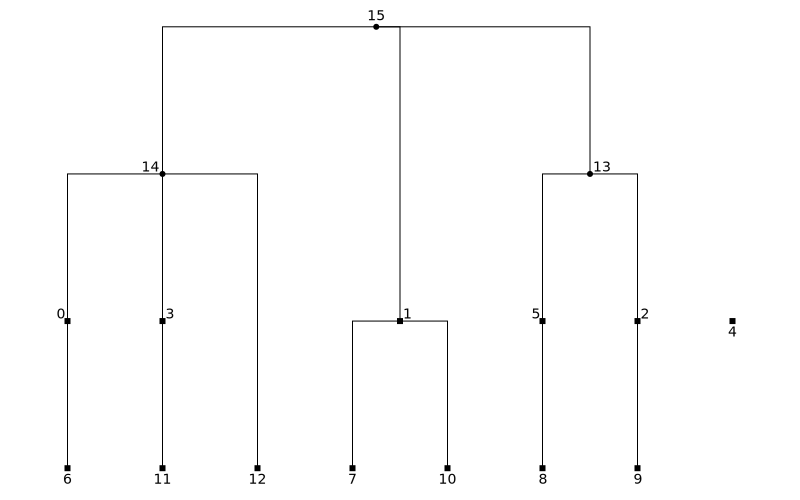

In [429]:
ts = tables.tree_sequence()
tree = ts.first()
SVG(tree.draw(width=800, height=500))

In [224]:
tree.num_roots

3

In [200]:
samples=np.where(tables.nodes.time == 0.0)[0]

In [201]:
tables.simplify(samples=samples.tolist())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [202]:
node_map = tables.simplify(samples=samples.tolist())
{node_map[node]: node for node in range(len(node_map))}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}

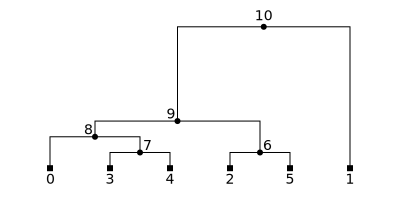

In [203]:
samples=np.where(tables.nodes.time == 0.0)[0]
node_map = tables.simplify(samples=samples.tolist())

ts = tables.tree_sequence()
tree = ts.first()
inverse_map = {node_map[node]: node for node in range(len(node_map))}
labels = {u: "{}->{}".format(inverse_map[u], u) for u in tree.nodes()}

SVG(tree.draw(height=200, width=400))

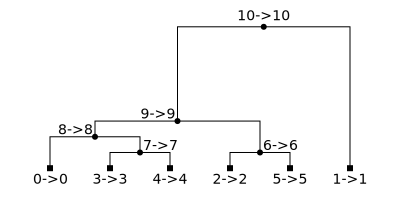

In [204]:
SVG(tree.draw(height=200, width=400, node_labels=labels))